### **데이터 불러오기**

In [ ]:
from google.colab import drive
drive.mount('/content/mydrive')

Drive already mounted at /content/mydrive; to attempt to forcibly remount, call drive.mount("/content/mydrive", force_remount=True).


In [ ]:
# matplotlib 한글 깨짐 방지
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
# 런타임 다시시작

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-nanum all 20180306-3 [9,599 kB]
Fetched 9,599 kB in 1s (14.9 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 122545 files and dir

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# 데이터 불러오기
data = pd.read_csv('/content/mydrive/MyDrive/ESAA_cj_공모전/data/tmk_bda_train.csv', index_col=0, encoding='UTF-8')
data

,scd,product_name,net_order_qty,net_order_amt,gender,age_grp,employee_yn,order_date,prime_yn
0,20230124153976,잔칫집 식혜 240ml 30입,1,9.803170,F,2,Y,20230124,N
1,20230124155563,백설 한입쏙 비엔나 120g*2,1,8.256607,M,3,Y,20230124,N
2,20230125158386,비비고 왕교자 1.05kg,1,9.348449,F,4,N,20230125,N
3,20230126164638,고메 바삭쫄깃한 탕수육 900g,1,9.667259,F,4,N,20230126,Y
4,20230125159705,햇반 매일잡곡밥210g,20,9.994653,M,4,N,20230125,Y
...,...,...,...,...,...,...,...,...,...
45870,20230102972321,고메 거멍 모짜체다핫도그 340g,1,8.648397,M,5,Y,20230102,Y
45871,20230102972720,[앱전용특가]비비고 차돌된장찌개 460gX4개,1,9.639327,F,3,N,20230102,N
45872,20230101964953,[앱전용특가]비비고 차돌된장찌개 460gX4개,1,9.639327,F,4,N,20230101,N
45873,20230101970142,[식물성]고메 플랜테이블 함박스테이크 150g,1,7.939872,M,4,Y,20230101,Y


---

##**가설 및 EDA**




In [ ]:
# 임직원/비임직원 분리
Y_data = data[data["employee_yn"] == "Y"]
N_data = data[data["employee_yn"] == "N"]

In [ ]:
# 폰트설정
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

### **1. 비임직원**

**1-1. 성별은 프라임 회원 여부에 영향을 줄 것이다**

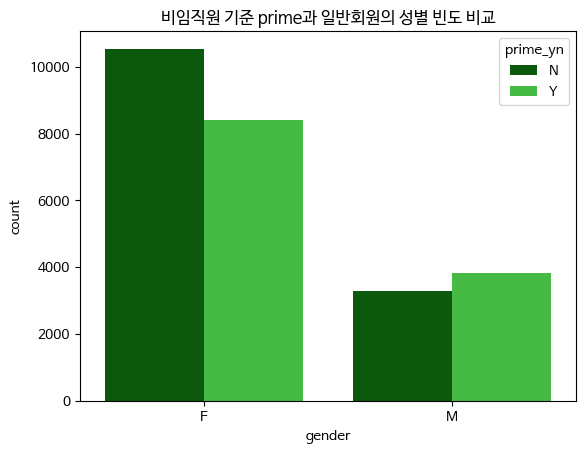

In [ ]:
# 비임직원 구매고객 성별과 prime
colors = ["darkgreen", "limegreen"]
sns.countplot(x=N_data["gender"],hue=data['prime_yn'], palette=colors)
plt.title('비임직원 기준 prime과 일반회원의 성별 빈도 비교')
plt.show()

구매고객 성별 행태를 보면 여성이 남성보다 많고 prime고객도 더 많다. 

그리고 남성은 prime이 일반회원보다 많지만 여성은 일반회원이 더 많다. 

이처럼 두 성별에 따라 다른 경향을 보이기 때문에 성별은 유의미한 변수이다.

\

**1-2. 연령대는 프라임 회원 여부에 영향을 줄 것이다**

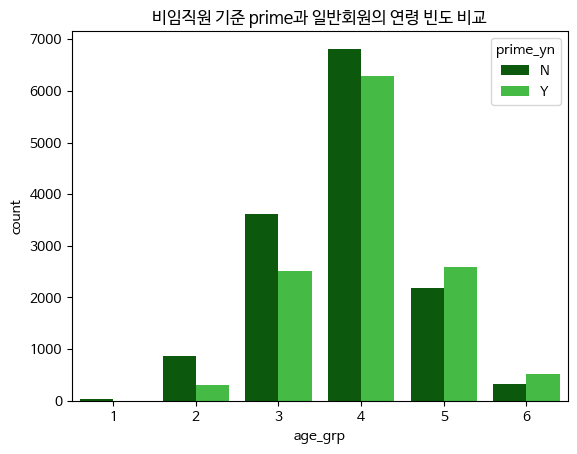

In [ ]:
# 비임직원 구매고객 연령과 prime
sns.countplot(x=N_data["age_grp"],hue=data['prime_yn'], palette=colors)
plt.title('비임직원 기준 prime과 일반회원의 연령 빈도 비교')
plt.show()

40대 고객이 우세하며 비교적 10,20,60대의 구매는 저조한 것으로 보인다.

따라서 CJ 더마켓 이용고객은 30,40대에 치우쳐져있기 때문에 연령은 중요한 변수이다.

\

**1-3. 프라임 회원은 일반 회원보다 1인당 평균 주문 금액이 더 클 것이다.**

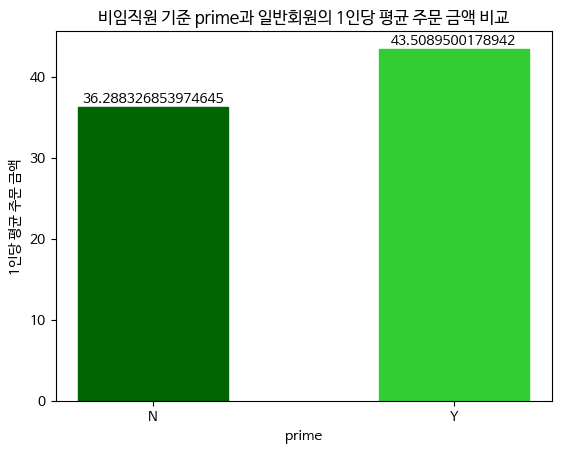

In [ ]:
# 비임직원 구매고객 주문 금액과 prime
grouped_data = N_data.groupby('prime_yn')['net_order_amt'].sum()

# 그래프 데이터 및 레이블 설정
groups = grouped_data.index.tolist()
amount_data = grouped_data.tolist()
amount_data[0]=amount_data[0]/len(N_data[N_data['prime_yn']=='N']['scd'].unique())
amount_data[1]=amount_data[1]/len(N_data[N_data['prime_yn']=='Y']['scd'].unique())

# 그래프 설정
bar_width = 0.5
index = range(len(groups))

# 그래프 그리기
fig, ax = plt.subplots()
bars = ax.bar(index, amount_data, bar_width)
ax.set_xlabel('prime')
ax.set_ylabel('1인당 평균 주문 금액')
ax.set_title('비임직원 기준 prime과 일반회원의 1인당 평균 주문 금액 비교')
ax.set_xticks(index)
ax.set_xticklabels(groups)

# 색상설정
bars[0].set_color('darkgreen')
bars[1].set_color('limegreen')

# 레이블 표시
for rect in bars:
    height = rect.get_height()
    ax.annotate(f'{height}', xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points', ha='center')

# 그래프 보여주기
plt.show()

prime 회원의 1인당 평균 주문 금액이 더 많다. 

일반 회원들은 거래 지향적 구매를 하므로 할인 행사 상품이나 이벤트 상품 위주로
구매한다. 

따라서 프라임 회원보다 상대적으로 주문 금액이 적을 것으로 예상된다. 

또한, 빅인의 이커머스 트렌드 리포트에 따르면 충성 고객은 일반 고객 대비 한 번 구매할 때의 객단가가 평균적으로 507.08% 높게 나타난다.

따라서 1인당 평균 주문금액이 높을 수록 prime일가능성이 높다.

\

**1-4. 프라임 회원은 일반 회원보다 1인당 평균 주문 수량이 더 클 것이다.**

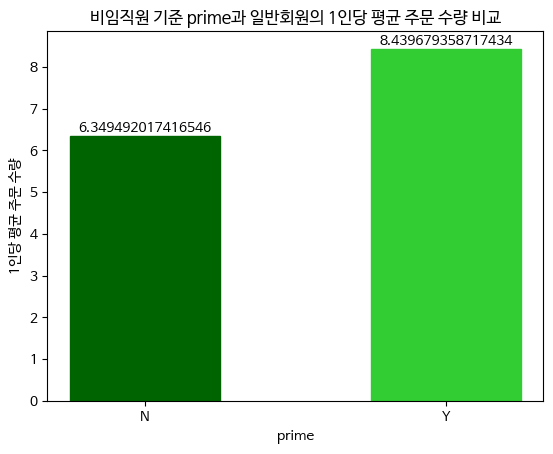

In [ ]:
# 주문 수량과 prime
grouped_data = N_data.groupby('prime_yn')['net_order_qty'].sum()

# 그래프 데이터 및 레이블 설정
groups = grouped_data.index.tolist()
amount_data = grouped_data.tolist()
amount_data[0]=amount_data[0]/len(N_data[N_data['prime_yn']=='N']['scd'].unique())
amount_data[1]=amount_data[1]/len(N_data[N_data['prime_yn']=='Y']['scd'].unique())

# 그래프 설정
bar_width = 0.5
index = range(len(groups))

# 그래프 그리기
fig, ax = plt.subplots()
bars = ax.bar(index, amount_data, bar_width)
ax.set_xlabel('prime')
ax.set_ylabel('1인당 평균 주문 수량')
ax.set_title('비임직원 기준 prime과 일반회원의 1인당 평균 주문 수량 비교')
ax.set_xticks(index)
ax.set_xticklabels(groups)

# 색상설정
bars[0].set_color('darkgreen')
bars[1].set_color('limegreen')

# 레이블 표시
for rect in bars:
    height = rect.get_height()
    ax.annotate(f'{height}', xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points', ha='center')

# 그래프 보여주기
plt.show()

시각화 결과, 비임직원 기준에서 prime회원이 일반회원보다 1인당 평균 주문 수량이 더 많다.

현재로서도 주문 수량은 유의미한 변수이지만, <br/> 상품명에 ‘개’,‘입’ 등 수량 정보를 담은 추가적인 데이터들이 존재하므로 주문 수량에 관한 변수를 가공해야할 필요가 있다. 

이에 관한 자세한 내용은 전처리 부분에서 설명할 예정이다.

\

* **상품명 키워드 빈도 워드클라우드** 

In [ ]:
! pip install pandas matplotlib wordcloud
! pip install konlpy --quiet

# 나눔폰트 설치 
!sudo apt-get install -y fonts-nanum    
!sudo fc-cache -fv                      
!rm ~/.cache/matplotlib -rf     

# 런타임 다시시작

import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 36.9 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipp

In [ ]:
# 나눔폰트 설정
import  matplotlib.font_manager  as fm
from wordcloud  import WordCloud

font_path = "/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf"

font_name  = fm.FontProperties(fname=font_path, size=12).get_name( )

plt.rc("font", family= font_name)

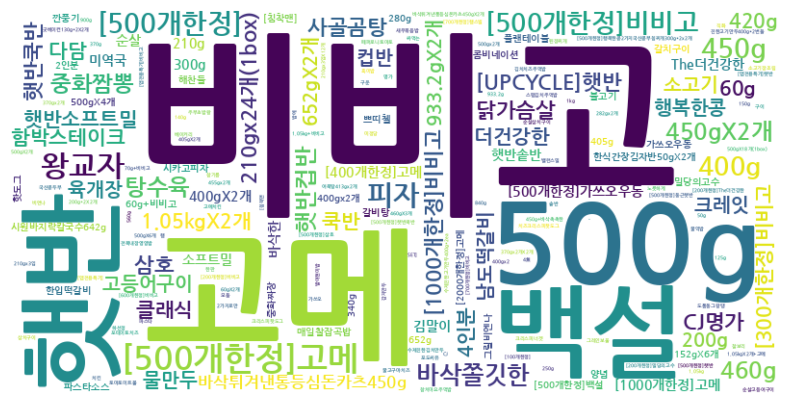

In [ ]:
words = N_data['product_name'].str.split().explode()
word_counts = words.value_counts()
wordcloud = WordCloud(font_path=font_path, width=800, height=400, background_color='white').generate_from_frequencies(word_counts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

상품명을 관찰해보면 주로 구매하는 상품들의 키워드를 파악할 수 있다. '비비고', '고메','햇반' 처럼 주로 cj더마켓의 주력 상품임을 알 수 있다. 

또한 '500개 한정' 키워드를 보면 cj더마켓에서 진행하는 이벤트가 구매에 영향을 많이 미칠 것이라고 예상되며, <br/> 450gx2개와 같이 수량에 관한 키워드도 존재함을 알 수 있다.


**1-5. 할인 및 이벤트 기간 내에 주문했는지가 프라임 회원 여부에 영향을 줄 것이다.**



 * 이벤트 기간 (1/1~1/11) 전과 후의 prime, 일반회원 주문 건수 비교





In [ ]:
# 일자를 datetime으로 변경
N_data['order_date']=pd.to_datetime(N_data['order_date'].astype(str), format='%Y%m%d')

# 이벤트 진행기간(1/1 ~ 1/11)을 추출하여 이벤트기간(event_yn)에 1 넣기
N_data['event_yn']=0
N_data.loc[(N_data['order_date'] >= '2023-01-01') & (N_data['order_date']<='2023-01-11'),'event_yn']=1

<ipython-input-14-e23a34dcc1b4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  N_data['order_date']=pd.to_datetime(N_data['order_date'].astype(str), format='%Y%m%d')
<ipython-input-14-e23a34dcc1b4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  N_data['event_yn']=0


In [ ]:
N_data['event_yn'].value_counts()
N_data[N_data['prime_yn']=='Y']['event_yn'].value_counts()

0    9283
1    2950
Name: event_yn, dtype: int64

In [ ]:
N_data[N_data['prime_yn']=='N']['event_yn'].value_counts()

0    10787
1     3050
Name: event_yn, dtype: int64

In [ ]:
print("일반회원 이벤트기간 이용비율:" ,len(N_data[N_data['prime_yn']=='N'][N_data[N_data['prime_yn']=='N']['event_yn']==1]) / len(N_data[N_data['prime_yn']=='N']))
print("prime 이벤트기간 이용비율:" ,len(N_data[N_data['prime_yn']=='Y'][N_data[N_data['prime_yn']=='Y']['event_yn']==1]) / len(N_data[N_data['prime_yn']=='Y']))

일반회원 이벤트기간 이용비율: 0.220423502204235
prime 이벤트기간 이용비율: 0.2411509850404643


기존 데이터를 관찰하기 전, 일반 고객들은 가격에 대한 관심도를 기반으로하는 거래 지향적 구매를 하는 것으로 판단되어 <br/>일반회원고객들이 이벤트기간 이용비율이 높을 것이라고 예상하였다. 

하지만 실제 데이터를 관찰한 결과 비임직원의 경우 프라임 회원이 이벤트 기간에 상품을 구매하는 빈도가 일반 회원보다 더 높았다.

이는 첫 달 무료 체험 등 프라임 회원 가입의 허들이 낮아짐에 따라, 프라임 회원이 충성 고객뿐만 아니라 일반 고객도 포함하기 때문으로 보인다.

이벤트 기간에 주문했는지 여부가 프라임과 비프라임을 구분하는
유용한 척도가 될 수 있다는 대전제는 변하지 않았으므로, 가설을 유지한다.


 * 상품명에 이벤트 정보 포함된 키워드 

 앱전용특가 /~개 한정/ 설선물

In [ ]:
app = N_data[N_data['product_name'].str.contains('앱전용특가')]
print("일반회원 앱전용특가 이용비율:" ,len(app[app['prime_yn']=='N']) / len(N_data[N_data['prime_yn']=='N']))
print("prime 앱전용특가 이용비율:" ,len(app[app['prime_yn']=='Y']) / len(N_data[N_data['prime_yn']=='Y']))

일반회원 앱전용특가 이용비율: 0.014454000144540001
prime 앱전용특가 이용비율: 0.014550805199051746


In [ ]:
limit = N_data[N_data['product_name'].str.contains('한정')]
print("일반회원 한정 이용비율:" ,len(limit[limit['prime_yn']=='N']) / len(N_data[N_data['prime_yn']=='N']))
print("prime 한정 이용비율:" ,len(limit[limit['prime_yn']=='Y']) / len(N_data[N_data['prime_yn']=='Y']))

일반회원 한정 이용비율: 0.308592903085929
prime 한정 이용비율: 0.31864628463990846


In [ ]:
seol = N_data[N_data['product_name'].str.contains('설선물')]
print("일반회원 설선물 이용비율:" ,len(seol[seol['prime_yn']=='N']) / len(N_data[N_data['prime_yn']=='N']))
print("prime 설선물 이용비율:" ,len(seol[seol['prime_yn']=='Y']) / len(N_data[N_data['prime_yn']=='Y']))

일반회원 설선물 이용비율: 0.015321240153212401
prime 설선물 이용비율: 0.0160222349382817


prime회원일수록 앱을 이용하거나 한정상품 구매, 설선물 구매 비율이 더 높다.

\

**1-6. 프라임 회원은 일반 회원보다 동시 주문 상품 종류의 개수가 많을 것이다.**

In [ ]:
#동시주문상품개수(net_order_type)
N_data['net_order_type'] = N_data.groupby('scd')['scd'].transform('size')

N_group_data = N_data.groupby('scd').agg({'gender': 'first', 'age_grp': 'first', 'net_order_qty' : 'sum',
                                      'net_order_amt': 'sum','employee_yn':'first',
                                      'order_date':'first','prime_yn':'first','net_order_type':'first','event_yn':'first'
                                      }).reset_index()

<ipython-input-21-a6fdcc09fd76>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  N_data['net_order_type'] = N_data.groupby('scd')['scd'].transform('size')


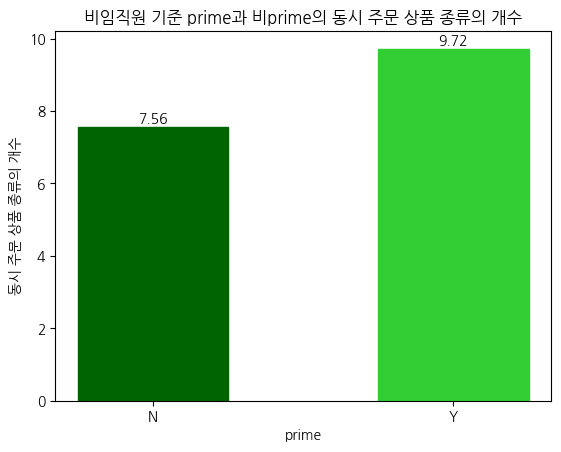

In [ ]:
# 'prime' 칼럼이 'Y'와 'N'인 두 그룹으로 분할
N_group_data = N_data.groupby('prime_yn')['net_order_type'].mean()

# 그래프 데이터 및 레이블 설정
groups = N_group_data.index.tolist()
mean_counts = N_group_data.tolist()

# 그래프 설정
bar_width = 0.5
index = range(len(groups))

# 그래프 그리기
fig, ax = plt.subplots()
bars = ax.bar(index, mean_counts, bar_width)
ax.set_xlabel('prime')
ax.set_ylabel('동시 주문 상품 종류의 개수')
ax.set_title('비임직원 기준 prime과 비prime의 동시 주문 상품 종류의 개수')
ax.set_xticks(index)
ax.set_xticklabels(groups)

# 색상설정
bars[0].set_color('darkgreen')
bars[1].set_color('limegreen')

# 레이블 표시
for rect in bars:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points', ha='center')

# 그래프 보여주기
plt.show()

동시주문상품개수는 동일한 주문 번호를 기준으로 같은 고객이 동시에 주문한 상품의 개수이다.

동시주문상품 개수 평균을 보면, prime고객이 일반회원고객보다 크다.

빅인의 이커머스 트렌드 리포트에 따르면 충성고객은 4.57개, 일반 고객은 1.67개로 충성 고객은 일반 고객 대비 평균 173.74% 더 다양한 상품 가짓수를 구매한다. 두 고객층의 구매 상품 수는 가장 적게 차이 나는 곳에서는 38.52%, 많게는 697.42%로 유의한 차이를 보인다.

### **2. 임직원**

**2-1. 성별은 프라임 회원 여부에 영향을 줄 것이다**

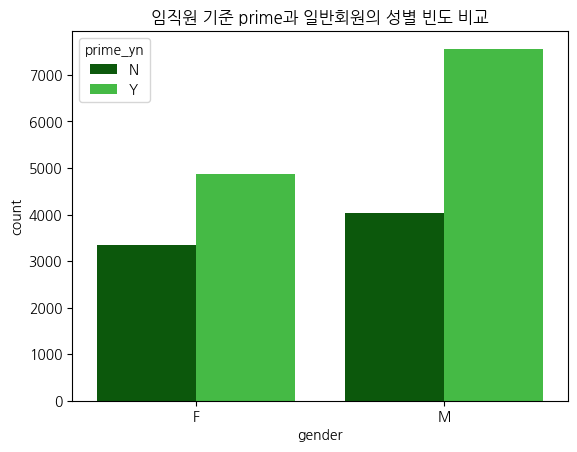

In [ ]:
# 비임직원 구매고객 성별과 prime
sns.countplot(x=Y_data["gender"],hue=data['prime_yn'], palette=colors)
plt.title('임직원 기준 prime과 일반회원의 성별 빈도 비교')
plt.show()

구매고객 성별 행태를 보면 남성이 여성보다 많고 prime고객도 남성이 더 많다. 


**1-2. 연령대는 프라임 회원 여부에 영향을 줄 것이다**

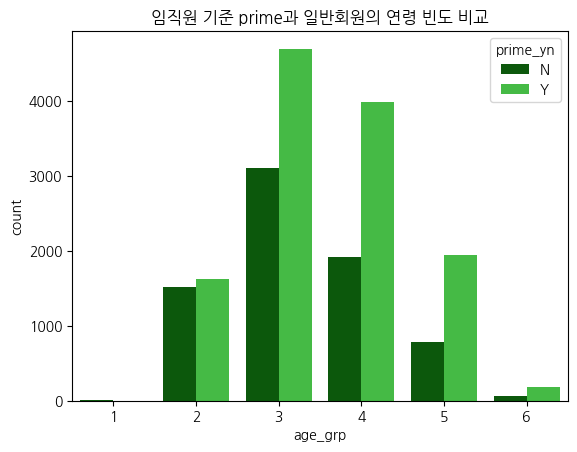

In [ ]:
# 비임직원 구매고객 연령과 prime
sns.countplot(x=Y_data["age_grp"],hue=data['prime_yn'], palette=colors)
plt.title('임직원 기준 prime과 일반회원의 연령 빈도 비교')
plt.show()

비임직원과 같은 양상을 보인다.


\

**1-3. 프라임 회원은 일반 회원보다 1인당 평균 주문 금액이 더 클 것이다.**

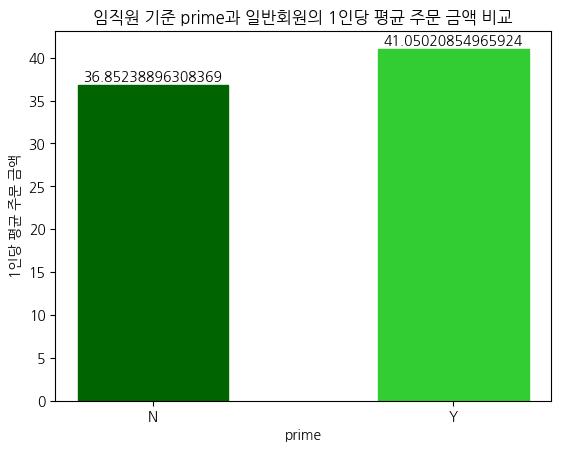

In [ ]:
# 비임직원 구매고객 주문 금액과 prime
grouped_data = Y_data.groupby('prime_yn')['net_order_amt'].sum()

# 그래프 데이터 및 레이블 설정
groups = grouped_data.index.tolist()
amount_data = grouped_data.tolist()
amount_data[0]=amount_data[0]/len(Y_data[Y_data['prime_yn']=='N']['scd'].unique())
amount_data[1]=amount_data[1]/len(Y_data[Y_data['prime_yn']=='Y']['scd'].unique())

# 그래프 설정
bar_width = 0.5
index = range(len(groups))

# 그래프 그리기
fig, ax = plt.subplots()
bars = ax.bar(index, amount_data, bar_width)
ax.set_xlabel('prime')
ax.set_ylabel('1인당 평균 주문 금액')
ax.set_title('임직원 기준 prime과 일반회원의 1인당 평균 주문 금액 비교')
ax.set_xticks(index)
ax.set_xticklabels(groups)

# 색상설정
bars[0].set_color('darkgreen')
bars[1].set_color('limegreen')

# 레이블 표시
for rect in bars:
    height = rect.get_height()
    ax.annotate(f'{height}', xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points', ha='center')

# 그래프 보여주기
plt.show()

비임직원과 동일하게 prime인 고객의 1인당 평균 주문 금액이 더 많다.

\

**1-4. 프라임 회원은 일반 회원보다 1인당 평균 주문 수량이 더 클 것이다.**

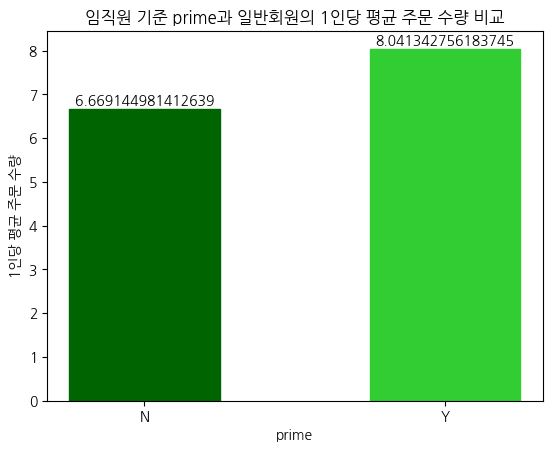

In [ ]:
# 주문 수량과 prime
grouped_data = Y_data.groupby('prime_yn')['net_order_qty'].sum()

# 그래프 데이터 및 레이블 설정
groups = grouped_data.index.tolist()
amount_data = grouped_data.tolist()
amount_data[0]=amount_data[0]/len(Y_data[Y_data['prime_yn']=='N']['scd'].unique())
amount_data[1]=amount_data[1]/len(Y_data[Y_data['prime_yn']=='Y']['scd'].unique())

# 그래프 설정
bar_width = 0.5
index = range(len(groups))

# 그래프 그리기
fig, ax = plt.subplots()
bars = ax.bar(index, amount_data, bar_width)
ax.set_xlabel('prime')
ax.set_ylabel('1인당 평균 주문 수량')
ax.set_title('임직원 기준 prime과 일반회원의 1인당 평균 주문 수량 비교')
ax.set_xticks(index)
ax.set_xticklabels(groups)

# 색상설정
bars[0].set_color('darkgreen')
bars[1].set_color('limegreen')

# 레이블 표시
for rect in bars:
    height = rect.get_height()
    ax.annotate(f'{height}', xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points', ha='center')

# 그래프 보여주기
plt.show()

임직원도 마찬가지로 prime회원이 일반회원보다 1인당 평균 주문 수량이 더 많다.

하지만 앞서 비임직원에서 설명한 내용과 동일하게 상품명에도 수량 정보가 포함되어있으므로 이를 모두 고려해야한다.

\


* **상품명 키워드 빈도 워드클라우드** 

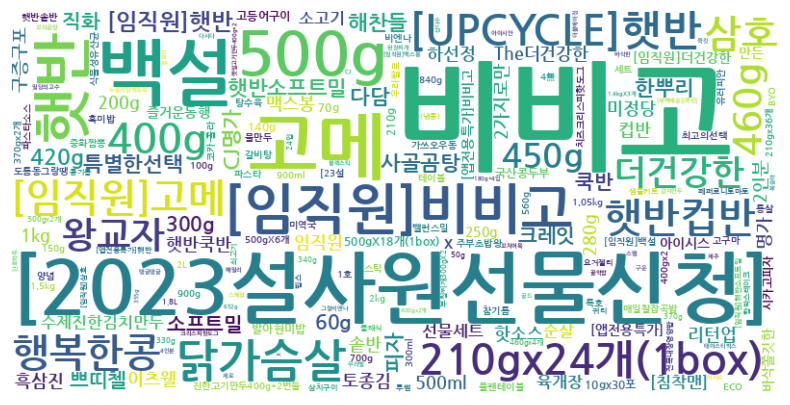

In [ ]:
words = Y_data['product_name'].str.split().explode()
word_counts = words.value_counts()
wordcloud = WordCloud(font_path=font_path,width=800, height=400, background_color='white').generate_from_frequencies(word_counts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

임직원도 마찬가지로 주로 구매하는 제품의 키워드는 '비비고', '고메','햇반'등 주류 상품이다.

임직원에서는 '설사원선물신청'이 매우 높은 빈도로 나타난다. 해당 키워드들을 이벤트 칼럼에서 사용한다.

또, 앞서 비임직원과 동일하게 수량 데이터도 존재하므로 이를 고려해야한다.


**1-5. 할인 및 이벤트 기간 내에 주문했는지가 프라임 회원 여부에 영향을 줄 것이다.**


 * 이벤트 기간 (1/1~1/11) 전과 후의 prime, 일반회원 주문 건수 비교





In [ ]:
# 일자를 datetime으로 변경
Y_data['order_date']=pd.to_datetime(Y_data['order_date'].astype(str), format='%Y%m%d')

# 이벤트 진행기간(1/1 ~ 1/11)을 추출하여 이벤트기간(event_yn)에 1넣기
Y_data['event_yn']=0
Y_data.loc[(Y_data['order_date'] >= '2023-01-01') & (Y_data['order_date']<='2023-01-11'),'event_yn']=1

<ipython-input-28-3004c494e66f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_data['order_date']=pd.to_datetime(Y_data['order_date'].astype(str), format='%Y%m%d')
<ipython-input-28-3004c494e66f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_data['event_yn']=0


In [ ]:
print("일반회원 이벤트기간 이용비율:" ,len(Y_data[Y_data['prime_yn']=='N'][Y_data[Y_data['prime_yn']=='N']['event_yn']==1]) / len(Y_data[Y_data['prime_yn']=='N']))
print("prime 이벤트기간 이용비율:" ,len(Y_data[Y_data['prime_yn']=='Y'][Y_data[Y_data['prime_yn']=='Y']['event_yn']==1]) / len(Y_data[Y_data['prime_yn']=='Y']))

일반회원 이벤트기간 이용비율: 0.23212351029252437
prime 이벤트기간 이용비율: 0.2176153288785122


비임직원과 다르게 임직원은 prime회원보다 일반회원이 이벤트기간 내 이용비율이 더 높다.

임직원은 일반회원이 이벤트기간 내 집중적인 구매행태를 보인다. 

따라서 일반회원은 이벤트기간에 영향을 많이 받는다.

 * 상품명에 이벤트 정보 포함된 키워드 

 앱전용특가 /~개 한정/ 설선물

In [ ]:
app = Y_data[Y_data['product_name'].str.contains('앱전용특가')]
print("일반회원 앱전용특가 이용비율:" ,len(app[app['prime_yn']=='N']) / len(Y_data[Y_data['prime_yn']=='N']))
print("prime 앱전용특가 이용비율:" ,len(app[app['prime_yn']=='Y']) / len(Y_data[Y_data['prime_yn']=='Y']))

일반회원 앱전용특가 이용비율: 0.018824485373781147
prime 앱전용특가 이용비율: 0.023991627083165608


In [ ]:
limit = Y_data[Y_data['product_name'].str.contains('한정')]
print("일반회원 한정 이용비율:" ,len(limit[limit['prime_yn']=='N']) / len(Y_data[Y_data['prime_yn']=='N']))
print("prime 한정 이용비율:" ,len(limit[limit['prime_yn']=='Y']) / len(Y_data[Y_data['prime_yn']=='Y']))

일반회원 한정 이용비율: 0.00013542795232936077
prime 한정 이용비율: 0.00032203526286128333


In [ ]:
seol = Y_data[Y_data['product_name'].str.contains('설선물')]
print("일반회원 설선물 이용비율:" ,len(seol[seol['prime_yn']=='N']) / len(Y_data[Y_data['prime_yn']=='N']))
print("prime 설선물 이용비율:" ,len(seol[seol['prime_yn']=='Y']) / len(Y_data[Y_data['prime_yn']=='Y']))

일반회원 설선물 이용비율: 0.005417118093174431
prime 설선물 이용비율: 0.0026567909186055874


In [ ]:
seol_em = Y_data[Y_data['product_name'].str.contains('설사원')]
print("일반회원 설사원 이용비율:" ,len(seol_em[seol_em['prime_yn']=='N']) / len(Y_data[Y_data['prime_yn']=='N']))
print("prime 설사원 이용비율:" ,len(seol_em[seol_em['prime_yn']=='Y']) / len(Y_data[Y_data['prime_yn']=='Y']))

일반회원 설사원 이용비율: 0.08856988082340195
prime 설사원 이용비율: 0.09427582320264069


In [ ]:
family = Y_data[Y_data['product_name'].str.contains('패밀리데이')]
print("일반회원 패밀리데이 이용비율:" ,len(family[family['prime_yn']=='N']) / len(Y_data[Y_data['prime_yn']=='N']))
print("prime 패밀리데이 이용비율:" ,len(family[family['prime_yn']=='Y']) / len(Y_data[Y_data['prime_yn']=='Y']))

일반회원 패밀리데이 이용비율: 0.01042795232936078
prime 패밀리데이 이용비율: 0.01457209564447307


In [ ]:
birth = Y_data[Y_data['product_name'].str.contains('생일 선물')]
print("일반회원 생일 선물 이용비율:" ,len(birth[birth['prime_yn']=='N']) / len(Y_data[Y_data['prime_yn']=='N']))
print("prime 생일 선물 이용비율:" ,len(birth[birth['prime_yn']=='Y']) / len(Y_data[Y_data['prime_yn']=='Y']))

일반회원 생일 선물 이용비율: 0.002979414951245937
prime 생일 선물 이용비율: 0.001449158682875775


임직원의 '앱전용특가'와 '~개한정' 데이터는 비임직원과 마찬가지로 prime회원의 이용비율이 더 높다. 하지만 '설선물' 구매는 일반회원 이용비율이 더 높다. 

더불어 임직원은 '설사원', '패밀리데이', '생일 선물' 이벤트가 추가적으로 진행된다. 

'설사원', '패밀리데이'는 prime고객 이용비율이 더 높으며 생일 선물은 일반회원 이용 비율이 더 높다. 

따라서 각각의 이벤트 칼럼을 나눠 새롭게 생성해줘야한다.




\

**1-6. 프라임 회원은 일반 회원보다 동시 주문 상품 종류의 개수가 많을 것이다.**

In [ ]:
# 동시주문상품개수(net_order_type)
Y_data['net_order_type'] = Y_data.groupby('scd')['scd'].transform('size')

Y_group_data = Y_data.groupby('scd').agg({'gender': 'first', 'age_grp': 'first', 'net_order_qty' : 'sum',
                                      'net_order_amt': 'sum','employee_yn':'first',
                                      'order_date':'first','prime_yn':'first','net_order_type':'first','event_yn':'first'
                                      }).reset_index()

<ipython-input-36-23363fb327c6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_data['net_order_type'] = Y_data.groupby('scd')['scd'].transform('size')


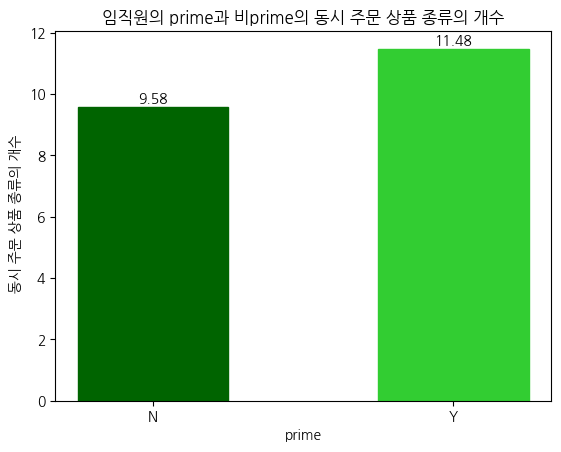

In [ ]:
# 'prime' 칼럼이 'Y'와 'N'인 두 그룹으로 분할
Y_group_data = Y_data.groupby('prime_yn')['net_order_type'].mean()

# 그래프 데이터 및 레이블 설정
groups = Y_group_data.index.tolist()
mean_counts = Y_group_data.tolist()

# 그래프 설정
bar_width = 0.5
index = range(len(groups))

# 그래프 그리기
fig, ax = plt.subplots()
bars = ax.bar(index, mean_counts, bar_width)
ax.set_xlabel('prime')
ax.set_ylabel(' 동시 주문 상품 종류의 개수')
ax.set_title('임직원의 prime과 비prime의 동시 주문 상품 종류의 개수')
ax.set_xticks(index)
ax.set_xticklabels(groups)

# 색상설정
bars[0].set_color('darkgreen')
bars[1].set_color('limegreen')

# 레이블 표시
for rect in bars:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points', ha='center')

# 그래프 보여주기
plt.show()

앞서 비임직원과 동일하게 prime회원이 일반회원보다 더 많은 가짓수의 상품을 구매한다.


In [ ]:
# EDA 완료, 전처리 시작 데이터 다시 불러오기
# 데이터 불러오기
data = pd.read_csv('/content/mydrive/MyDrive/ESAA_cj_공모전/data/tmk_bda_train.csv', index_col=0, encoding='UTF-8')
data

,scd,product_name,net_order_qty,net_order_amt,gender,age_grp,employee_yn,order_date,prime_yn
0,20230124153976,잔칫집 식혜 240ml 30입,1,9.803170,F,2,Y,20230124,N
1,20230124155563,백설 한입쏙 비엔나 120g*2,1,8.256607,M,3,Y,20230124,N
2,20230125158386,비비고 왕교자 1.05kg,1,9.348449,F,4,N,20230125,N
3,20230126164638,고메 바삭쫄깃한 탕수육 900g,1,9.667259,F,4,N,20230126,Y
4,20230125159705,햇반 매일잡곡밥210g,20,9.994653,M,4,N,20230125,Y
...,...,...,...,...,...,...,...,...,...
45870,20230102972321,고메 거멍 모짜체다핫도그 340g,1,8.648397,M,5,Y,20230102,Y
45871,20230102972720,[앱전용특가]비비고 차돌된장찌개 460gX4개,1,9.639327,F,3,N,20230102,N
45872,20230101964953,[앱전용특가]비비고 차돌된장찌개 460gX4개,1,9.639327,F,4,N,20230101,N
45873,20230101970142,[식물성]고메 플랜테이블 함박스테이크 150g,1,7.939872,M,4,Y,20230101,Y


---

## **<train 전처리>**



### **1.칼럼 변경 및 생성**

#### **1-1. 주문수량(net_order_qty) 칼럼 변경**

해당 데이터에서 주문수량을 가공하지않고 그대로 사용하면 문제점이 발생한다. 

가령 생수1통을 3개 구매한 것과, 생수3묶음을 1개 구매할 때 실제수량은 3개로 동일하나 데이터에 반영된 주문수량(net_order_qty)은 3과1로 모순되는 상황이 발생한다.

또한 상품명에는 용량 및 개/입에 대한 정보가 포함되어있는 경우도 있다.

따라서 이를 가공하지 않고 사용하기에는 수치적 영향을 많이 받을 것이라고 판단되어 **상품명에서 수량과 관련한 부분을 추출**하고 이를 반영하여 주문수량(net_order_qty)칼럼 값을 변경한다.

##### **(1) 수량 추출에 불필요 데이터 사전제거**

(1-1) 먼저 개/입 추출시 상품수량이 아닌 다른 정보가 반영되는 것을 막기 위해 불필요한 데이터를 사전제거한다.
- product_name에서 [] 안에 들어있는 ~개 한정, 임직원 등의 데이터 사전 제거
- 이후 product_info에 해당 정보 추가 -> product_name에서는 product_info 내용 삭제

In [ ]:
# 대괄호 안에 있는 정보를 추출하여 'product_info'에 저장
data['product_info'] = data['product_name'].str.findall(r'\[(.*?)\]')

# 추출된 정보를 문자열로 변환
data['product_info'] = data['product_info'].apply(lambda x: ', '.join(x) if x else '')

# 'product_name'에서 '[1000개한정미당정'를 추출하여 'product_info'에 저장
data.loc[data['product_name'].str.contains(r'\[1000개한정미정당'), 'product_info'] = '[1000개한정미정당'

# 'product_name'에서 'product_info'를 제외 (불필요 데이터 제거 작업)
data['product_name'] = data.apply(lambda x: re.sub(r'\[(.*?)\]', '', x['product_name']).strip(), axis=1)

# 'product_name'에서 정확한 '[1000개한정미당정'를 제거
data['product_name'] = data['product_name'].str.replace(r'\[1000개한정미정당', '').str.strip()

# 교체로 인해 발생하는 여분의 공간 제거
data['product_name'] = data['product_name'].str.strip()

<ipython-input-39-cc8ebe4a9332>:14: FutureWarning: The default value of regex will change from True to False in a future version.
  data['product_name'] = data['product_name'].str.replace(r'\[1000개한정미정당', '').str.strip()


(1-2) 용량 데이터도 수량 추출시 불필요하므로 사전 제거한다.

* g, G, kg, KG, ml, L 등이 포함된 용량 데이터 추출 후 product_name에서 제거
- 용량이 두 가지 이상일 경우 ,로 이어서 모두 추출

In [ ]:
# 불필요한 문자(g,G,kg 등 용량데이터)없이 원하는 정보를 추출할 수 있는 정규식 패턴 정의
pattern_gram = r'(\d+(?:\.\d+)?\s*[gGmMlLkK]+)'

# 정규식을 사용하여 'product_name'에서 수량 정보 추출
data['product_gram'] = data['product_name'].str.extractall(pattern_gram, flags=re.IGNORECASE).groupby(level=0).agg(','.join)
data['product_gram'] = data['product_gram'].str.strip()

# 추출된 수량 정보를 'product_name'에서 제거
data['product_name'] = data['product_name'].str.replace(pattern_gram, '')

# 교체로 인해 발생하는 여분의 공간 제거
data['product_name'] = data['product_name'].str.strip()

# 데이터 프레임 인덱스 재설
data = data.reset_index(drop=True)

<ipython-input-40-7ca1a203fdd2>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  data['product_name'] = data['product_name'].str.replace(pattern_gram, '')


In [ ]:
data['product_name'].head(20)

0                잔칫집 식혜  30입
1              백설 한입쏙 비엔나 *2
2                    비비고 왕교자
3               고메 바삭쫄깃한 탕수육
4                   햇반 매일잡곡밥
5          햇반 흑미밥 x24개(1box)
6                  햇반 매일찰잡곡밥
7         맥스봉 체다치즈어랏 (*20EA)
8             고메 바삭쫄깃한 사천탕수육
9               고메 콘크림수프 *4입
10             더건강한 닭가슴살 소시지
11                비비고 도톰해물완자
12                가쓰오얼큰우동2인분
13              고메 치즈크리스피핫도그
14              비비고 깻잎고기만두*2
15      행복한콩 2가지로만 국산콩두부 부침용
16               고메 칠리감바스 피자
17    사골곰탕 한 그릇  (1-2인분X5개입)
18                   고메 중화짬뽕
19             고메 포테이토치즈 핫도그
Name: product_name, dtype: object

용량과 ~개한정, [] 정보들이 삭제된 것을 확인할 수 있다.



##### **(2) 수량 데이터 추출** <br/>
입, 개, 묶음, box, 번들, 캔 등과 같이 수량 단위를 이용하여 수량 데이터를 추출한다.
- 위와 같은 수량단위를 기준으로 수량을 추출한 후 숫자만 남기고 한글은 제거
- 이후 product_name에서 제거

**※ 고려해야할 점**

- 개입, EA, 종, 묶음 등은 수량에 반영하지 않는다.
 
  - 12입(6입x묶음)처럼 동일한 수량이 반복되는 경우가 존재하므로 반영x
  - () 안에 필요한 수량 정보가 들어가있는 경우도 있고, 아닌 경우도 있기 때문에 수량 선처리 후 () 처리 진행
  - 패키지 구성품이 몇 개 들어있는지는 핵심 수량이 아니다.
    
    ex1) 20개의 소세지가 들어있는 맥스봉 소세지 상품 1개를 구매한 것이 20개의 수량으로 들어가는 문제점

- **입, 개, 캔, *2, X2, 번들**이 수량과 직접적인 연관이 있는 키워드는 반드시 반영



**(2-1) 수량 사전 작업 (1) - 개입/인분**


필요 없는 숫자 데이터이므로 추출 후 삭제

In [ ]:
import pandas as pd
import re

# 원하는 정보를 추출할 정규식 패턴 정의
pattern_count1 = r'(\d+(?:일|이|삼|사|오|육|칠|팔|구|십|백|천|만)*(?:개입|인분))'

# 앞에서 설정한 정규식인 pattern_count1을 사용하여 'product_name'에서 정보 추출하여 'product_count1'으로 저장
data['product_count1'] = data['product_name'].str.extract(pattern_count1, flags=re.IGNORECASE)

# 추출된 product_count1 정보를 문자열로 변환
data['product_count1'] = data['product_count1'].astype(str)

# 추출된 product_count1 정보를 'product_name'에서 제거
data['product_name'] = data['product_name'].str.replace(pattern_count1, '')

# 교체로 인해 발생하는 여분의 공간 제거
data['product_name'] = data['product_name'].str.strip()

# 데이터 프레임의 인덱스 재설정
data = data.reset_index(drop=True)

<ipython-input-42-d00065561686>:14: FutureWarning: The default value of regex will change from True to False in a future version.
  data['product_name'] = data['product_name'].str.replace(pattern_count1, '')


**(2-2) 수량 사전 작업 (2) - 인/EA/종/묶음/캡슐/포/정/구/매 추출** <br/>
필요 없는 숫자 데이터이므로 추출 후 삭제

In [ ]:
# 정규식을 사용하여 'product_name' 열에서 일치하는 모든 수량 추출
pattern_count2 = r'(\d+(?:일|이|삼|사|오|육|칠|팔|구|십|백|천|만)*(?:\s?(?:인|EA|ea|종|묶음|캡슐|포|정|구|매)))'
data['product_count2'] = data['product_name'].str.extract(pattern_count2, flags=re.IGNORECASE)

# 'product_name'에서 추출한 'number + EA', 'number + 종', 'number + 묶음'을 제거
data['product_name'] = data['product_name'].str.replace(pattern_count2, '')

# 교체로 인해 발생하는 여분의 공간 제거
data['product_name'] = data['product_name'].str.strip()

# 데이터 프레임의 인덱스 재설정
data = data.reset_index(drop=True)

<ipython-input-43-19022f48a08a>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  data['product_name'] = data['product_name'].str.replace(pattern_count2, '')


**(2-3) 수량 처리 - 팩/개/번들/캔 추출** <br/>
필요한 데이터이므로 추출 후 숫자는 남겨두고 문자만 삭제한다.
- 두 가지 이상일 경우 ,로 이어서 모두 추출할 수 있게 한다.

In [ ]:
# 숫자+팩/개/번들/캔 정보를 추출할 정규식 패턴 정의
pattern_count = r'(\d+(?:일|이|삼|사|오|육|칠|팔|구|십|백|천|만)*[~팩개번들캔])'

#앞에서 설정한 정규식인 pattern_count1을 사용하여 'product_name'에서 정보 추출하여 'product_count'으로 저장
data['product_count'] = data['product_name'].str.findall(pattern_count, flags=re.UNICODE)

# product_name에서 product_count를 제거
data['product_name'] = data['product_name'].str.replace(pattern_count, '', regex=True)

# 여분의 공간 제거
data['product_name'] = data['product_name'].str.strip()

# product_count 열을 숫자만 포함하도록 업데이트
data['product_count'] = data['product_count'].apply(lambda x: ','.join(re.findall(r'\d+', ','.join(x))))

# 데이터 프레임의 인덱스 재설정
data = data.reset_index(drop=True)

**(2-4) 수량 사전 작업 (3)  - () 제거** <br/>
() 안에 있는 중복되는 수량 데이터를 사전 제거
- ex. 1box, 40입 (20입x2묶음) 등
- 추후 활용될 여지가 없는 데이터이므로 삭제

In [ ]:
# 정규표현식을 사용하여()추출 후 'product_info2'열에 저장
data['product_info2'] = data['product_name'].str.findall(r'\((.*?)\)')

# 추출된 정보를 문자열로 변환
data['product_info2'] = data['product_info2'].apply(lambda x: ', '.join(x) if x else '')

#'product_name'에서 'product_info'를 제외
data['product_name'] = data.apply(lambda x: re.sub(r'\((.*?)\)', '', x['product_name']).strip(), axis=1)

# 교체로 인해 발생하는 여분의 공간제거
data['product_name'] = data['product_name'].str.strip()

**(2-5) 수량 2차 처리 - 입 추출** <Br/>
() 안에 같은 수량을 표시하는 입이 들어가는 문제 해결하기 위해 () 처리 후 추출한다.
- 필요한 데이터이므로 숫자는 남겨두고 문자만 삭제한다.

In [ ]:
# '*입'이 있는 정보를 추출할 정규식 패턴 정의
pattern_count3 = r'(\d+(?:일|이|삼|사|오|육|칠|팔|구|십|백|천|만)*입)'

#앞에서 설정한 정규식인 pattern_count1을 사용하여 'product_name'에서 정보 추출하여 'product_count3'으로 저장
data['product_count3'] = data['product_name'].str.extract(pattern_count3, flags=re.IGNORECASE)

# 문자열로 변환
data['product_count3'] = data['product_count3'].astype(str)

# 추출된 product_count3 정보를 'product_name'에서 제거
data['product_name'] = data['product_name'].str.replace(pattern_count3, '')

# 교체로 인해 발생하는 여분의 공간제거
data['product_name'] = data['product_name'].str.strip()

# 'x'가 포함된 product_count3 열의 값을 공백으로 변경
data['product_count3'] = data['product_count3'].replace('.*x.*', '', regex=True)

# product_count3 열을 숫자만 포함하도록 업데이트
data['product_count3'] = data['product_count3'].str.extract(r'(\d+)')

#'product_count3' 열이 비어 있는 행 삭제
data = data[data['product_count3'].str.strip().astype(bool)]

# 데이터 프레임의 인덱스 재설정
data = data.reset_index(drop=True)

<ipython-input-46-1ae44beb2ffe>:11: FutureWarning: The default value of regex will change from True to False in a future version.
  data['product_name'] = data['product_name'].str.replace(pattern_count3, '')


**(2-6) 수량 3차 처리 - *숫자, x숫자, X숫자 추출** <Br/>
- x가 여러 번 있는 경우를 고려하여 *, x, X 뒤에 있는 숫자 데이터를 모두 남겨둔다.

In [ ]:
# 'product_name'에서 'x', 'X', '*' 뒤에 최대 2글자를 추출하여 'product_count4'에 저장
data['product_count4'] = data['product_name'].str.extract(r'[xX*](?:\+)?(.{0,2})')

# 추출로 인한 여분의 공간 제거
data['product_count4'] = data['product_count4'].str.strip()

# 'product_name'에서 추출된 정보를 제거
data['product_name'] = data['product_name'].str.replace(r'[xX*](?:\+)?.{0,2}', '')

# 교체로 인해 발생하는 여분의 공간제거
data['product_name'] = data['product_name'].str.strip()

# 데이터 프레임의 인덱스 재설정
data = data.reset_index(drop=True)

<ipython-input-47-e9908362ea5e>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  data['product_name'] = data['product_name'].str.replace(r'[xX*](?:\+)?.{0,2}', '')


##### **(3) 최종 수량 데이터 생성** <br/>

- 앞의 과정으로부터 유의미한 수량인 product_count, produt_count3, product_count4 모두 곱하여 total_count로 지정
- net_order_qty에 total_count 곱하기

**(3-1) product_count 곱연산**

In [ ]:
# product_count 열에 두 개의 숫자를 곱함
data['product_count'] = data['product_count'].apply(lambda x: str(int(x.split(',')[0]) * int(x.split(',')[1])) if ',' in x else x)

**(3-2) product_count 하나로 합치기**

In [ ]:
# 숫자 데이터 형식으로 변환
data['product_count'] = pd.to_numeric(data['product_count'], errors='coerce')
data['product_count3'] = pd.to_numeric(data['product_count3'], errors='coerce')
data['product_count4'] = pd.to_numeric(data['product_count4'], errors='coerce')

# 앞에서 생성한 유의미한 숫자 칼럼들 모두 곱한 값을 'total_count'에 저장
data['total_count'] = (data['product_count'].fillna(1) * data['product_count3'].fillna(1) * data['product_count4'].fillna(1))

**(3-3) total_count와 net_order_qty 곱하기**

In [ ]:
# 숫자 데이터 형식으로 변환
data['total_count'] = pd.to_numeric(data['total_count'], errors='coerce')
data['net_order_qty'] = pd.to_numeric(data['net_order_qty'], errors='coerce')

# 'net_order_qty'와 'total_count'를 곱하여 'net_order_qty'에 저장
data['net_order_qty'] = (data['net_order_qty'].fillna(1) * data['total_count'].fillna(1))

##### **(4) 임시 칼럼들 drop**

In [ ]:
# info
data = data.drop(['product_info', 'product_info2'], axis=1)

# gram
data = data.drop(['product_gram'], axis=1)

# count
data = data.drop(['total_count', 'product_count', 'product_count1', 'product_count2', 'product_count3', 'product_count4'], axis=1)

##### **(5) product_name 원본 불러오기**


앞서 진행했던 net_order_qty를 처리할 때 product_name에 변화가 있었으므로, 다시 product_name을 불러와서 우리의 데이터에 'product_realname' 변수로 넣어준다.

In [ ]:
# 상품명을 가져오기 위하여 다시 데이터 불러오기
data2 = pd.read_csv('/content/mydrive/MyDrive/ESAA_cj_공모전/data/tmk_bda_train.csv', index_col=0)  
# 실제 상품명을 data에 새로운 칼럼('product_realname')을 사용하여 넣어주기
data['product_realname'] = data2['product_name']

In [ ]:
data

,scd,product_name,net_order_qty,net_order_amt,gender,age_grp,employee_yn,order_date,prime_yn,product_realname
0,20230124153976,잔칫집 식혜,30.0,9.803170,F,2,Y,20230124,N,잔칫집 식혜 240ml 30입
1,20230124155563,백설 한입쏙 비엔나,2.0,8.256607,M,3,Y,20230124,N,백설 한입쏙 비엔나 120g*2
2,20230125158386,비비고 왕교자,1.0,9.348449,F,4,N,20230125,N,비비고 왕교자 1.05kg
3,20230126164638,고메 바삭쫄깃한 탕수육,1.0,9.667259,F,4,N,20230126,Y,고메 바삭쫄깃한 탕수육 900g
4,20230125159705,햇반 매일잡곡밥,20.0,9.994653,M,4,N,20230125,Y,햇반 매일잡곡밥210g
...,...,...,...,...,...,...,...,...,...,...
45870,20230102972321,고메 거멍 모짜체다핫도그,1.0,8.648397,M,5,Y,20230102,Y,고메 거멍 모짜체다핫도그 340g
45871,20230102972720,비비고 차돌된장찌개,4.0,9.639327,F,3,N,20230102,N,[앱전용특가]비비고 차돌된장찌개 460gX4개
45872,20230101964953,비비고 차돌된장찌개,4.0,9.639327,F,4,N,20230101,N,[앱전용특가]비비고 차돌된장찌개 460gX4개
45873,20230101970142,고메 플랜테이블 함박스테이크,1.0,7.939872,M,4,Y,20230101,Y,[식물성]고메 플랜테이블 함박스테이크 150g


#### **1-2. 비주류유무(non_main_yn)칼럼 생성**

해당 칼럼은 product_name (상품명)이 CJ 더마켓의 비주력 상품인지에 대한 정보를 담고있다.

주류 키워드가 없는 상품명 데이터의 경우, 비주류 칼럼(non_main_yn)에 1을 넣는다.

주류 키워드는 cj더마켓 홈페이지 상품 카테고리에서 '밥/죽/면 ~ 스팸/닭가슴살/소시지','밀키트' 키워드를 추출하여 사용하였다.

해당 키워드로 추출하면 비주류인 '소스' 상품이 주류에 포함되는 문제가 발생하므로, <br/> '스파게티소스, 파스타소스, 돈까스 소스'인덱스를 따로 추출하여 비주류 칼럼에 1을 넣는다.

※ 현재 홈페이지에 기재된 상품명을 사용하지 않고 키워드만 뽑아낸 이유는, <br/> 5월인 현재 CJ더마켓의 상품명과 1월에 판매한 상품명 다르기 때문에 1월인 데이터에는 적용할 수 없다고 판단했다.

In [ ]:
# main 키워드
exclude_words =['비비고','고메','밸런스밀','햇반','맥스봉','더건강한',  '행복한콩','밀당의고수','토종김',
                '즐거운동행','크레잇','스팸', '육공육','삼호','명가','햄스빌','미정당','맛밤','주부초밥왕',
                '쁘띠첼','플랜테이블','톡톡까먹어밤','쿡킷','쿠캣','딜라이트','주부유부왕', '밥이랑','그레인보울','밀키트',
                '비요뜨','옥사부반점','계절밥상','VIPS','비엔나','우동','곰탕','우엉','깐메추리알','간짜장',
                '동치미','도시락','쌀국수','새우까스','햄','돈까스', '만두', '단무지', '두부', '갈비탕', '소바', '너겟', 
                '생면', '소시지', '바삭칩', '너비아니', '해쉬브라운', '당면', '사천마라탕면', '후랑크', '야채고기말이', 
                '스파게티', '파스타', '닭갈비','쌈무', '가쓰오','치킨', '단무지', '견과','냉동감자','포켓팝콘','그릴스모크',
                '소면','냉면','찹스테이크','쯔란갈비','새우튀김','불고기','동그랑땡','칼국수','아이스크림','중면','대란','윙봉',
                '볶음밥','피자','폭립','파히타','감바스','고르곤졸라','멕시칸타코','밀키트','선물','특별한선택','최고의선택']

In [ ]:
# non_main 데이터들의 인덱스 저장 (상품명에 main키워드가 존재하지 않는 데이터)
non_main_index1 = data[~data['product_realname'].str.contains('|'.join(exclude_words))].index

# non_main인 '스파게티소스, 파스타소스, 돈까스 소스' 인덱스 따로 저장
non_main_index2 = data[data['product_realname'].str.contains('|'.join(['스파게티소스','파스타소스', '돈까스 소스']))].index

# 최종 non_main 인덱스 생성
non_main_index = non_main_index1.union(non_main_index2)
non_main_index 

Int64Index([    0,    20,    23,    27,    47,    48,    51,    53,    56,
               59,
            ...
            45762, 45773, 45776, 45777, 45793, 45804, 45812, 45854, 45869,
            45874],
           dtype='int64', length=5645)

In [ ]:
# non_main 상품명들 확인
non_main= data[~data['product_realname'].str.contains('|'.join(exclude_words))]

In [ ]:
# non_main 상품 데이터는 비주류 칼럼(non_main_yn)에 1 넣기
data.loc[non_main_index, 'non_main_yn'] = 1
data['non_main_yn'] =data['non_main_yn'].fillna(0)

#### **1-3. 이벤트 칼럼 생성**



**1-3-1. 이벤트 기간(event_yn)**

In [ ]:
# 일자를 datetime으로 변경
data['order_date']=pd.to_datetime(data['order_date'].astype(str), format='%Y%m%d')

In [ ]:
# 이벤트 진행기간(1/1 ~ 1/11)을 추출하여 이벤트기간(event_yn)에 1넣기
data['event_yn']=0
data.loc[(data['order_date'] >= '2023-01-01') & (data['order_date']<='2023-01-11'),'event_yn']=1
# 설 선물도 이벤트 기간 내 속하므로 반영
event_index = data[data['product_realname'].str.contains('|'.join(['설선물']))].index
data.loc[event_index, 'event_yn'] = 1

In [ ]:
data[['order_date','event_yn']]

,order_date,event_yn
0,2023-01-24,0
1,2023-01-24,0
2,2023-01-25,0
3,2023-01-26,0
4,2023-01-25,0
...,...,...
45870,2023-01-02,1
45871,2023-01-02,1
45872,2023-01-01,1
45873,2023-01-01,1


**1-3-2. 앱전용특가(app_yn)**

In [ ]:
# 상품명(product_realname)에 '앱전용특가'가 있는 상품들은 앱전용특가(app_yn)에 1넣기
app_index= data[data['product_realname'].str.contains('앱전용특가')].index
data.loc[app_index, 'app_yn'] = 1
data['app_yn'] =data['app_yn'].fillna(0)

**1-3-3. 패밀리데이(family_yn)**

In [ ]:
# 상품명(product_realname)에 '패밀리데이'가 있는 상품들은 패밀리데이(family_yn)에 1넣기
family_index= data[data['product_realname'].str.contains('패밀리데이')].index
data.loc[family_index, 'family_yn'] = 1
data['family_yn'] =data['family_yn'].fillna(0)

**1-3-4. 한정(limited_yn)**

In [ ]:
# 상품명(product_realname)에 '한정'가 있는 상품들은 한정(limited_yn)에 1넣기
limited_index= data[data['product_realname'].str.contains('한정')].index
data.loc[limited_index, 'limited_yn'] = 1
data['limited_yn'] =data['limited_yn'].fillna(0)

**1-3-5. 설사원(empseol_yn)/생일 선물(birthday_yn)/설선물(seol_yn)**

In [ ]:
# 설사원 - 임직원 데이터에 존재
# 상품명(product_realname)에 '설사원'가 있는 상품들은 설사원(empseol_yn)에 1넣기
empseol_index= data[data['product_realname'].str.contains('설사원')].index
data.loc[empseol_index, 'empseol_yn'] = 1
data['empseol_yn'] =data['empseol_yn'].fillna(0)

In [ ]:
# 생일선물 - 임직원 데이터에 존재
# 상품명(product_realname)에 '생일 선물'가 있는 상품들은 생일 선물(birthday_yn)에 1넣기
birthday_index= data[data['product_realname'].str.contains('생일 선물')].index
data.loc[birthday_index, 'birthday_yn'] = 1
data['birthday_yn'] =data['birthday_yn'].fillna(0)

In [ ]:
# 설선물 - 비임직원 데이터에 존재
# 상품명(product_realname)에 '설선물'가 있는 상품들은 설선물(seol_yn)에 1넣기
seol_index= data[data['product_realname'].str.contains('설선물')].index
data.loc[seol_index, 'seol_yn'] = 1
data['seol_yn'] =data['seol_yn'].fillna(0)

### **2. 주문번호 카테고리화**

#### **2-1. 동시주문상품개수(net_order_type)**

같은 주문번호 개수를 세어 한 번 구매시 구매한 상품의 개수 합하여 'net_order_type'칼럼에 넣는다.


In [ ]:
# 동시주문상품개수(net_order_type)
data['net_order_type'] = data.groupby('scd')['scd'].transform('size')

#### **2-2 group_data 프레임 생성**

주문번호(scd)별로 groupby하여 새로운 데이터 프레임(group_data)을 생성한다.

수치에 영향이 미치는  'net_order_qty' , 'net_order_amt',	'non_main_yn','app_yn', 'family_yn', 'limited_yn','birthday_yn','seol_yn','empseol_yn' 칼럼은 모두 더하고, 나머지 칼럼은 주문자가 동일하다면 데이터가 동일하기 때문에 first값을 사용한다.

In [ ]:
group_data = data.groupby('scd').agg({'gender': 'first', 'age_grp': 'first', 'net_order_qty' : 'sum',
                                      'net_order_amt': 'sum','employee_yn':'first',
                                      'order_date':'first','prime_yn':'first',	'non_main_yn':'sum','net_order_type':'first',
                                      'app_yn':'sum','family_yn':'sum','limited_yn':'sum',
                                      'birthday_yn':'sum','seol_yn':'sum','empseol_yn':'sum','event_yn':'first',
                                      
                                      }).reset_index()
group_data

,scd,gender,age_grp,net_order_qty,net_order_amt,employee_yn,order_date,prime_yn,non_main_yn,net_order_type,app_yn,family_yn,limited_yn,birthday_yn,seol_yn,empseol_yn,event_yn
0,20230101963226,M,3,52.0,39.433806,Y,2023-01-01,N,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0,1
1,20230101963235,F,4,2.0,19.234566,Y,2023-01-01,Y,0.0,2,0.0,0.0,0.0,0.0,0.0,2.0,1
2,20230101963244,F,4,6.0,10.234373,N,2023-01-01,Y,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,1
3,20230101963247,M,3,10.0,45.516855,Y,2023-01-01,Y,0.0,5,0.0,0.0,0.0,0.0,0.0,0.0,1
4,20230101963251,F,3,48.0,10.845621,Y,2023-01-01,Y,1.0,1,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10648,20230131216756,F,4,3.0,18.314758,N,2023-01-31,N,0.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0
10649,20230131216771,F,4,2.0,9.125762,N,2023-01-31,Y,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0
10650,20230131216842,M,3,24.0,10.176411,N,2023-01-31,N,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0
10651,20230131216844,F,4,11.0,44.927942,N,2023-01-31,N,2.0,5,0.0,0.0,0.0,0.0,0.0,0.0,0


### **3. 비주류유무(non_main_yn)칼럼 단순 sum에서 비율로 변경**

현재 주문번호별로 그룹화한 비주류유무(non_main_yn) 칼럼은 단순 sum으로 계산된 값이다. 

비주류 상품을 하나라도 구매한 고객을 살펴본 결과, 많은 고객이 비주류 상품을 1개 이상 구매하였기 때문에 비율로 나타내는 것이 타당하다고 판단하였다.

In [ ]:
# 고객이 구매한 상품의 비주류 비율
group_data['non_main_yn'] = group_data['non_main_yn'] / group_data['net_order_type']
# 칼럼명 변경
group_data.rename(columns={'non_main_yn': 'non_main'}, inplace=True)

In [ ]:
group_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10653 entries, 0 to 10652
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   scd             10653 non-null  int64         
 1   gender          10653 non-null  object        
 2   age_grp         10653 non-null  int64         
 3   net_order_qty   10653 non-null  float64       
 4   net_order_amt   10653 non-null  float64       
 5   employee_yn     10653 non-null  object        
 6   order_date      10653 non-null  datetime64[ns]
 7   prime_yn        10653 non-null  object        
 8   non_main        10653 non-null  float64       
 9   net_order_type  10653 non-null  int64         
 10  app_yn          10653 non-null  float64       
 11  family_yn       10653 non-null  float64       
 12  limited_yn      10653 non-null  float64       
 13  birthday_yn     10653 non-null  float64       
 14  seol_yn         10653 non-null  float64       
 15  em

### **4. 인코딩**

각 연령대별로 원핫인코딩을 진행하고 타겟변수는 라벨인코딩 한다.

성별은 빈도인코딩을 하여 새로운 칼럼(gender_freq_enc)을 만들고 기존의 성별(gender)칼럼은 삭제한다.
 
구매 고객 성별 분포를 보면, 비임직원의 경우 여성이 남성보다 많으며, prime도 여성이 많다. <br/> 임직원의 경우는 반대로 남성이 여성보다 많으며, prime도 남성이 더 많다. 

따라서 비임직원과 임직원 모두 성별 간의 성별 빈도에서 유의미한 차이가 존재하므로 빈도 인코딩을 사용하였다.

In [ ]:
# 연령대(age_grp) 원핫인코딩
group_data = pd.get_dummies(group_data, columns=['age_grp'], prefix=['age_grp'])

# 타겟변수(prime_yn) 라벨인코딩
label_encoder = LabelEncoder()
group_data['prime_yn'] = label_encoder.fit_transform(group_data['prime_yn'])

# 성별(gender) 빈도인코딩
frequency_encoding = group_data['gender'].value_counts(normalize=True).to_dict()

# 성별 빈도(gender_freq_enc)칼럼 생성
group_data['gender_freq_enc'] = group_data['gender'].map(frequency_encoding)

# 기존 성별(gender)칼럼 삭제
group_data =group_data.drop('gender', axis=1)

### **5.임직원/비임직원 분리**

In [ ]:
# 임직원
employee_data = group_data[group_data['employee_yn']=='Y']
# 비임직원
n_employee_data = group_data[group_data['employee_yn']=='N']

---

## **모델링 (xgboost)**

#### **1. 비임직원**

임직원에만 존재하는 데이터인 생일 선물(birthday_yn), 패밀리데이(family_yn), 설사원(empseol_yn) 변수는 삭제한다. 

타겟변수(prime_yn), 일자변수(order_date), 임직원여부(employee_yn) 변수도 모델링에 이용하지 않으므로 삭제하고 최종 비임직원 데이터를 생성한다.



In [ ]:
# 비임직원 데이터
n_X = n_employee_data.drop(['prime_yn','scd','order_date','family_yn','birthday_yn','employee_yn','empseol_yn'], axis=1)
# 비임직원 타겟변수 데이터
n_y = n_employee_data['prime_yn']

In [ ]:
import xgboost as xgb
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score

# 모델 선언 - 하이퍼파라미터 튜닝 후 결정된 파라미터
n_xgb_clf = xgb.XGBClassifier(learning_rate=0.7, max_depth=4, n_estimators=700, subsample=0.8, colsample_bytree=0.8, gamma=0.1)

# cross-validation 진행 후 f1_score측정
scorer = make_scorer(f1_score)
scores = cross_val_score(n_xgb_clf, n_X, n_y, cv=5, scoring= scorer)

best_score = max(scores)
print("Best F1 score:", best_score)

Best F1 score: 0.5808257522743177


In [ ]:
scores

array([0.58082575, 0.53250774, 0.50539957, 0.55139289, 0.50515464])

- learning_rate=0.8, max_depth=4, n_estimators=700, subsample=0.8
  - Best F1 score: 0.5572354211663066 (cv=5)
- **learning_rate=0.7**, max_depth=4, **n_estimators=600**, subsample=0.8 
  - Best F1 score: 0.5772298767222626 (cv=5)
- learning_rate=0.7, max_depth=4, n_estimators=600, subsample=0.8, **colsample_bytree=0.8**, **gamma=0.1**
  - Best F1 score: 0.5772759350741001 (cv=5)
- learning_rate=0.7, max_depth=4, n_estimators=600, subsample=0.8, **colsample_bytree=0.9**, gamma=0.1
  - Best F1 score: 0.5718349928876245 (cv=5)
- learning_rate=0.7, max_depth=4, n_estimators=600, subsample=0.8, colsample_bytree=0.8, **gamma=0.2**
  - Best F1 score: 0.5765895953757225 (cv=5)
- learning_rate=0.7, max_depth=4, **n_estimators=700**, subsample=0.8, colsample_bytree=0.8, gamma=0.1
  - **Best F1 score: 0.5808257522743177** (cv=5)
  - Best F1 score: 0.5706093189964158 (Standardization)
  - Best F1 score: 0.5634408602150538 (Min-Max scaler)
  - Best F1 score: 0.5517241379310345 (net_order_qty 제외)
- learning_rate=0.7, max_depth=4, n_estimators=700, subsample=0.8, colsample_bytree=0.8, gamma=0.1, **reg_alpha = 0.1**
  - Best F1 score: 0.5562043795620438 (cv=5)
- learning_rate=0.7, max_depth=4, n_estimators=700, subsample=0.8, colsample_bytree=0.8, gamma=0.1, **reg_alpha = 0.01**
  - Best F1 score: 0.5771715721464465 (cv=5)
- learning_rate=0.7, max_depth=4, n_estimators=700, subsample=0.8, colsample_bytree=0.8, gamma=0.1, **min_child_weight = 1**
  - Best F1 score: 0.5808257522743177 (cv=5)

#### **2. 임직원**

In [ ]:
# 임직원 데이터
X = employee_data.drop(['prime_yn','order_date','scd', 'employee_yn'], axis=1)
# 임직원 타겟변수 데이터
y = employee_data['prime_yn']

In [ ]:
# 모델 선언 - 하이퍼파라미터 튜닝 후 결정된 파라미터
xgb_clf = xgb.XGBClassifier(learning_rate=0.1, max_depth=1, n_estimators=10, subsample=0.7, colsample_bytree=0.8, gamma=0.1)

# cross-validation 진행 후 f1_score측정
scorer = make_scorer(f1_score)
scores = cross_val_score(xgb_clf, X, y, cv=10, scoring= scorer)

best_score = max(scores)
print("Best F1 score:", best_score)

Best F1 score: 0.7510791366906476


- learning_rate=0.2, max_depth=1, n_estimators=100
  - Best F1 score: 0.7443881245474293 (cv=5)
- learning_rate=0.2, **max_depth=10**, n_estimators=100
  - Best F1 score: 0.7263922518159807 (cv=5)
- learning_rate=0.2, max_depth=1, **n_estimators=10**
  - Best F1 score: 0.7506631299734747 (cv=5)
- learning_rate=0.2, max_depth=1, n_estimators=10, **subsample=0.8, colsample_bytree=0.8, gamma=0.1**
  - Best F1 score: 0.7496688741721853 (cv=10)
- learning_rate=0.2, max_depth=1, n_estimators=10, **subsample=0.7**, colsample_bytree=0.8, gamma=0.1
  - Best F1 score: 0.748482805124747 (cv=5)
  - Best F1 score: 0.7506631299734747 (cv=10)
-learning_rate=0.2, max_depth=1, n_estimators=10, subsample=0.7, colsample_bytree=0.8, **gamma=0.2**
  - Best F1 score: 0.7506631299734747 (cv=10)
- **learning_rate=0.1**, max_depth=1, n_estimators=10, subsample=0.7, colsample_bytree=0.8, gamma=0.1
  - Best F1 score: 0.7510791366906476 (cv=10)

---

## **<test 전처리>**

앞서 진행한 train데이터 전처리와 동일하게 진행한다.

### **1.칼럼 변경 및 생성**



#### **1-1. 주문수량(net_order_qty) 칼럼 변경**



#### **(1) 수량 추출에 불필요 데이터 사전제거**

(1-1) 먼저 개/입 추출시 상품수량이 아닌 다른 정보가 반영되는 것을 막기 위해 불필요한 데이터를 사전제거한다.

In [ ]:
encoding='UTF-8'
test_data=pd.read_csv('/content/mydrive/MyDrive/ESAA_cj_공모전/data/tmk_bda_test.csv', index_col=0)
test_data=test_data.drop('prime_yn',axis=1) # 타겟칼럼 삭제

In [ ]:
test_data

,scd,product_name,net_order_qty,net_order_amt,gender,age_grp,employee_yn,order_date
45875,20230101964282,비비고 스팸부대찌개 460g,1,8.161946,M,4,N,20230101
45876,20230101970142,삼호 생선살어묵 야채 200g,1,8.098947,M,4,Y,20230101
45877,20230101965237,크레잇 블랙페퍼 폭찹 스테이크,1,8.277412,F,4,N,20230101
45878,20230102973798,비비고 소고기 미역국 500g,3,9.145375,F,3,N,20230102
45879,20230101965633,비비고 소고기 미역국 500g,2,8.613230,F,3,N,20230101
...,...,...,...,...,...,...,...,...
65530,20230103986821,비비고 찐만두168g,1,7.930566,M,5,Y,20230103
65531,20230102979023,사골곰탕 한 그릇 100g (1-2인분X5개입),1,8.477412,F,3,Y,20230102
65532,20230103989581,쁘띠첼 자몽상큼함듬뿍워터젤리 130ml,10,9.421249,F,3,Y,20230103
65533,20230104999357,비비고 언양식 바싹불고기 460g,1,8.594895,M,4,N,20230104


In [ ]:
# 대괄호 안에 있는 정보를 추출하여 'product_info'에 저장
test_data['product_info'] = test_data['product_name'].str.findall(r'\[(.*?)\]')

# 추출된 정보를 문자열로 변환
test_data['product_info'] = test_data['product_info'].apply(lambda x: ', '.join(x) if x else '')

# 'product_name'에서 '[1000개한정미당정'를 추출하여 'product_info'에 저장
test_data.loc[test_data['product_name'].str.contains(r'\[1000개한정미정당'), 'product_info'] = '[1000개한정미정당'

# 'product_name'에서 'product_info'를 제외 (불필요 데이터 제거 작업)
test_data['product_name'] = test_data.apply(lambda x: re.sub(r'\[(.*?)\]', '', x['product_name']).strip(), axis=1)

# 'product_name'에서 정확한 '[1000개한정미당정'를 제거
test_data['product_name'] = test_data['product_name'].str.replace(r'\[1000개한정미정당', '').str.strip()

# 교체로 인해 발생하는 여분의 공간 제거
test_data['product_name'] = test_data['product_name'].str.strip()

<ipython-input-80-b9477ed24f19>:14: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['product_name'] = test_data['product_name'].str.replace(r'\[1000개한정미정당', '').str.strip()


(1-2) 용량 데이터도 수량 추출시 불필요하므로 사전 제거한다.

In [ ]:
# 불필요한 문자(g,G,kg 등 용량데이터)없이 원하는 정보를 추출할 수 있는 정규식 패턴 정의
pattern_gram = r'(\d+(?:\.\d+)?\s*[gGmMlLkK]+)'

# 정규식을 사용하여 'product_name'에서 수량 정보 추출
test_data['product_gram'] = test_data['product_name'].str.extractall(pattern_gram, flags=re.IGNORECASE).groupby(level=0).agg(','.join)
test_data['product_gram'] = test_data['product_gram'].str.strip()

# 추출된 수량 정보를 'product_name'에서 제거
test_data['product_name'] = test_data['product_name'].str.replace(pattern_gram, '')

# 교체로 인해 발생하는 여분의 공간 제거
test_data['product_name'] = test_data['product_name'].str.strip()

# 데이터 프레임 인덱스 재설정
test_data = test_data.reset_index(drop=True)

<ipython-input-81-f6cd77c29bf9>:12: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['product_name'] = test_data['product_name'].str.replace(pattern_gram, '')


#### **(2) 수량 데이터 추출** <br/>


**(2-1) 수량 사전 작업 (1) - 개입/인분**


In [ ]:
import pandas as pd
import re

# 원하는 정보를 추출할 정규식 패턴 정의
pattern_count1 = r'(\d+(?:일|이|삼|사|오|육|칠|팔|구|십|백|천|만)*(?:개입|인분))'

# 앞에서 설정한 정규식인 pattern_count1을 사용하여 'product_name'에서 정보 추출하여 'product_count1'으로 저장
test_data['product_count1'] = test_data['product_name'].str.extract(pattern_count1, flags=re.IGNORECASE)

# 추출된 product_count1 정보를 문자열로 변환
test_data['product_count1'] = test_data['product_count1'].astype(str)

# 추출된 product_count1 정보를 'product_name'에서 제거
test_data['product_name'] = test_data['product_name'].str.replace(pattern_count1, '')

# 교체로 인해 발생하는 여분의 공간 제거
test_data['product_name'] = test_data['product_name'].str.strip()

# 데이터 프레임의 인덱스 재설정
test_data = test_data.reset_index(drop=True)

<ipython-input-82-fd6bd8999c9a>:14: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['product_name'] = test_data['product_name'].str.replace(pattern_count1, '')


**(2-2)  수량 사전 작업 (2) - 인/EA/종/묶음/캡슐/포/정/구/매 추출**

In [ ]:
# 정규식을 사용하여 'product_name' 열에서 일치하는 모든 수량 추출
pattern_count2 = r'(\d+(?:일|이|삼|사|오|육|칠|팔|구|십|백|천|만)*(?:\s?(?:인|EA|ea|종|묶음|캡슐|포|정|구|매)))'
test_data['product_count2'] = test_data['product_name'].str.extract(pattern_count2, flags=re.IGNORECASE)

# 'product_name'에서 추출한 'number + EA', 'number + 종', 'number + 묶음'을 제거
test_data['product_name'] = test_data['product_name'].str.replace(pattern_count2, '')

# 교체로 인해 발생하는 여분의 공간 제거
test_data['product_name'] = test_data['product_name'].str.strip()

# 데이터 프레임의 인덱스 재설정
test_data = test_data.reset_index(drop=True)

<ipython-input-83-ebc5fdd6a90b>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['product_name'] = test_data['product_name'].str.replace(pattern_count2, '')


**(2-3) 수량 처리 - 팩/개/번들/캔 추출** <br/>

In [ ]:
# 숫자+팩/개/번들/캔 정보를 추출할 정규식 패턴 정의
pattern_count = r'(\d+(?:일|이|삼|사|오|육|칠|팔|구|십|백|천|만)*[~팩개번들캔])'

# 앞에서 설정한 정규식인 pattern_count1을 사용하여 'product_name'에서 정보 추출하여 'product_count'으로 저장
test_data['product_count'] = test_data['product_name'].str.findall(pattern_count, flags=re.UNICODE)

# product_name에서 product_count를 제거
test_data['product_name'] = test_data['product_name'].str.replace(pattern_count, '', regex=True)

# 여분의 공간 제거
test_data['product_name'] = test_data['product_name'].str.strip()

# product_count 열을 숫자만 포함하도록 업데이트
test_data['product_count'] = test_data['product_count'].apply(lambda x: ','.join(re.findall(r'\d+', ','.join(x))))

# 데이터 프레임의 인덱스 재설정
test_data = test_data.reset_index(drop=True)

**(2-4) 수량 사전 작업 (3)  - () 제거**

In [ ]:
# 정규표현식을 사용하여()추출 후 'product_info2'열에 저장
test_data['product_info2'] = test_data['product_name'].str.findall(r'\((.*?)\)')

# 추출된 정보를 문자열로 변환
test_data['product_info2'] = test_data['product_info2'].apply(lambda x: ', '.join(x) if x else '')

#'product_name'에서 'product_info'를 제외
test_data['product_name'] = test_data.apply(lambda x: re.sub(r'\((.*?)\)', '', x['product_name']).strip(), axis=1)

# 교체로 인해 발생하는 여분의 공간제거
test_data['product_name'] = test_data['product_name'].str.strip()

**(2-5) 수량 2차 처리 - 입 추출** 

In [ ]:
# '*입'이 있는 정보를 추출할 정규식 패턴 정의
pattern_count3 = r'(\d+(?:일|이|삼|사|오|육|칠|팔|구|십|백|천|만)*입)'

# 앞에서 설정한 정규식인 pattern_count1을 사용하여 'product_name'에서 정보 추출하여 'product_count3'으로 저장
test_data['product_count3'] = test_data['product_name'].str.extract(pattern_count3, flags=re.IGNORECASE)

# 문자열로 변환
test_data['product_count3'] = test_data['product_count3'].astype(str)

# 추출된 product_count3 정보를 'product_name'에서 제거
test_data['product_name'] = test_data['product_name'].str.replace(pattern_count3, '')

# 교체로 인해 발생하는 여분의 공간제거
test_data['product_name'] = test_data['product_name'].str.strip()

# 'x'가 포함된 product_count3 열의 값을 공백으로 변경
test_data['product_count3'] = test_data['product_count3'].replace('.*x.*', '', regex=True)

# product_count3 열을 숫자만 포함하도록 업데이트
test_data['product_count3'] = test_data['product_count3'].str.extract(r'(\d+)')

#'product_count3' 열이 비어 있는 행 삭제
test_data = test_data[test_data['product_count3'].str.strip().astype(bool)]

# 데이터 프레임의 인덱스 재설정
test_data = test_data.reset_index(drop=True)

<ipython-input-86-a48d082903f3>:11: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['product_name'] = test_data['product_name'].str.replace(pattern_count3, '')


**(2-6) 수량 3차 처리 - *숫자, x숫자, X숫자 추출**

In [ ]:
# 'product_name'에서 'x', 'X', '*' 뒤에 최대 2글자를 추출하여 'product_count4'에 저장
test_data['product_count4'] = test_data['product_name'].str.extract(r'[xX*](?:\+)?(.{0,2})')

# 추출로 인한 여분의 공간 제거
test_data['product_count4'] = test_data['product_count4'].str.strip()

# 'product_name'에서 추출된 정보를 제거
test_data['product_name'] = test_data['product_name'].str.replace(r'[xX*](?:\+)?.{0,2}', '')

# 교체로 인해 발생하는 여분의 공간제거
test_data['product_name'] = test_data['product_name'].str.strip()

# 데이터 프레임의 인덱스 재설정
test_data = test_data.reset_index(drop=True)

<ipython-input-87-a8df11f0c118>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['product_name'] = test_data['product_name'].str.replace(r'[xX*](?:\+)?.{0,2}', '')


#### **3) 최종 수량 데이터 생성** <br/>

**(3-1) product_count 곱연산**

In [ ]:
# product_count 열에 두 개의 숫자를 곱함
test_data['product_count'] = test_data['product_count'].apply(lambda x: str(int(x.split(',')[0]) * int(x.split(',')[1])) if ',' in x else x)

**(3-2) product_count 하나로 합치기**

In [ ]:
# 숫자 데이터 형식으로 변환
test_data['product_count'] = pd.to_numeric(test_data['product_count'], errors='coerce')
test_data['product_count3'] = pd.to_numeric(test_data['product_count3'], errors='coerce')
test_data['product_count4'] = pd.to_numeric(test_data['product_count4'], errors='coerce')

# 앞에서 생성한 유의미한 숫자 칼럼들 모두 곱한 값을 'total_count'에 저장
test_data['total_count'] = (test_data['product_count'].fillna(1) * test_data['product_count3'].fillna(1) * test_data['product_count4'].fillna(1))

**(3-3) total_count와 net_order_qty 곱하기**

In [ ]:
# 숫자 데이터 형식으로 변환
test_data['total_count'] = pd.to_numeric(test_data['total_count'], errors='coerce')
test_data['net_order_qty'] = pd.to_numeric(test_data['net_order_qty'], errors='coerce')

# 'net_order_qty'와 'total_count'를 곱하여 'net_order_qty'에 저장
test_data['net_order_qty'] = (test_data['net_order_qty'].fillna(1) * test_data['total_count'].fillna(1))

#### **(4) 임시 칼럼들 drop**

In [ ]:
# info
test_data = test_data.drop(['product_info', 'product_info2'], axis=1)

# gram
test_data = test_data.drop(['product_gram'], axis=1)

# count
test_data = test_data.drop(['total_count', 'product_count', 'product_count1', 'product_count2', 'product_count3', 'product_count4'], axis=1)

In [ ]:
test_data

,scd,product_name,net_order_qty,net_order_amt,gender,age_grp,employee_yn,order_date
0,20230101964282,비비고 스팸부대찌개,1.0,8.161946,M,4,N,20230101
1,20230101970142,삼호 생선살어묵 야채,1.0,8.098947,M,4,Y,20230101
2,20230101965237,크레잇 블랙페퍼 폭찹 스테이크,1.0,8.277412,F,4,N,20230101
3,20230102973798,비비고 소고기 미역국,3.0,9.145375,F,3,N,20230102
4,20230101965633,비비고 소고기 미역국,2.0,8.613230,F,3,N,20230101
...,...,...,...,...,...,...,...,...
19655,20230103986821,비비고 찐만두,1.0,7.930566,M,5,Y,20230103
19656,20230102979023,사골곰탕 한 그릇,1.0,8.477412,F,3,Y,20230102
19657,20230103989581,쁘띠첼 자몽상큼함듬뿍워터젤리,10.0,9.421249,F,3,Y,20230103
19658,20230104999357,비비고 언양식 바싹불고기,1.0,8.594895,M,4,N,20230104


**(5) product_name 원본 불러오기**

In [ ]:
# 상품명을 가져오기 위하여 다시 데이터 불러오기
test_data2 = pd.read_csv('/content/mydrive/MyDrive/ESAA_cj_공모전/data/tmk_bda_test.csv', index_col=0,encoding='UTF-8')  
test_data2.reset_index(drop=True, inplace=True) 

# 실제 상품명을 data에 새로운 칼럼('product_realname')을 사용하여 넣어주기
test_data['product_realname'] = test_data2['product_name']

#### **1-2. 비주류유무(non_main_yn)칼럼 생성**

In [ ]:
# main 키워드
exclude_words =['비비고','고메','밸런스밀','햇반','맥스봉','더건강한',  '행복한콩','밀당의고수','토종김','즐거운동행','크레잇','스팸', '육공육','삼호','명가','햄스빌','미정당','맛밤','주부초밥왕',
'쁘띠첼','플랜테이블','톡톡까먹어밤','쿡킷','쿠캣','딜라이트','주부유부왕', '밥이랑','그레인보울','밀키트','비요뜨','옥사부반점','계절밥상','VIPS','비엔나','우동','곰탕','우엉','깐메추리알','간짜장',
'동치미','도시락','쌀국수','새우까스','햄','돈까스', '만두', '단무지', '두부', '갈비탕', '소바', '너겟', '생면', '소시지', '바삭칩', '너비아니', '해쉬브라운', '당면', '사천마라탕면', '후랑크', 
'야채고기말이', '스파게티', '파스타', '닭갈비','쌈무', '가쓰오','치킨', '단무지', '견과','냉동감자','포켓팝콘','그릴스모크','소면','냉면','찹스테이크','쯔란갈비','새우튀김','불고기','동그랑땡','칼국수','아이스크림','중면','대란','윙봉','볶음밥','피자','폭립','파히타','감바스','고르곤졸라','멕시칸타코','밀키트','선물','특별한선택','최고의선택']

# 스파게티소스, 파스타소스, 돈까스 소스 인덱스 따로 저장
non_main_index1 = test_data[~test_data['product_realname'].str.contains('|'.join(exclude_words))].index
non_main_index2 =test_data[test_data['product_realname'].str.contains('|'.join(['스파게티소스','파스타소스', '돈까스 소스']))].index
non_main_index = non_main_index1.union(non_main_index2)
non_main_index 

Int64Index([   14,    18,    24,    56,    66,    68,    70,    74,    75,
               84,
            ...
            19543, 19573, 19581, 19582, 19585, 19587, 19591, 19612, 19632,
            19648],
           dtype='int64', length=2261)

In [ ]:
# 비주류 상품명들 확인
non_main= test_data[~test_data['product_realname'].str.contains('|'.join(exclude_words))]
pd.DataFrame(non_main['product_realname'].value_counts())

,product_realname
찹쌀 호떡믹스 400g,55
[500개한정] 백설 포도씨유 900mlx2개,35
백설 참치액 진더풍부한맛 500g,31
백설 남해굴소스 500g,28
백설 소갈비양념 840g,27
...,...
바질&로즈마리드레싱 235g,1
[임직원]리턴업 콜레스테롤케어 60캡슐(1개월)x2개,1
양갈비 어깨살 300g+시즈닝 2종,1
[임직원]BYO 프리바이오틱스 FOS플러스 30포(1개월)x3개,1


In [ ]:
test_data.loc[non_main_index, 'non_main_yn'] = 1
test_data['non_main_yn'] =test_data['non_main_yn'].fillna(0)

#### **1-3. 이벤트 칼럼 생성**

**1-3-1. 이벤트 기간(event_yn)**

In [ ]:
# 일자 datetime으로 타입 변경
test_data['order_date']=pd.to_datetime(test_data['order_date'].astype(str), format='%Y%m%d')

In [ ]:
test_data['event_yn']=0
test_data.loc[(test_data['order_date'] >= '2023-01-01') & (test_data['order_date']<='2023-01-11'),'event_yn']=1

In [ ]:
# 설선물도 event기간에 포함되므로 추가 설정
event_index = test_data[test_data['product_realname'].str.contains('|'.join(['설선물']))].index
test_data.loc[event_index, 'event_yn'] = 1

**1-3-2. 앱전용특가(app_yn)**


In [ ]:
app_index= test_data[test_data['product_name'].str.contains('앱전용특가')].index
test_data.loc[app_index, 'app_yn'] = 1
test_data['app_yn'] =test_data['app_yn'].fillna(0)

**1-3-3. 패밀리데이(family_yn)**


In [ ]:
family_index= test_data[test_data['product_name'].str.contains('패밀리데이')].index
test_data.loc[family_index, 'family_yn'] = 1
test_data['family_yn'] =test_data['family_yn'].fillna(0)

In [ ]:
test_data['family_yn'].value_counts()

0.0    19583
1.0       77
Name: family_yn, dtype: int64

**1-3-4. 한정(limited_yn)**

In [ ]:
limited_index= test_data[test_data['product_name'].str.contains('한정')].index
test_data.loc[limited_index, 'limited_yn'] = 1
test_data['limited_yn'] =test_data['limited_yn'].fillna(0)

In [ ]:
test_data['limited_yn'].value_counts()

0.0    19660
Name: limited_yn, dtype: int64

**1-3-5. 설사원(empseol_yn)/생일 선물(birthday_yn)/설선물(seol_yn)**

In [ ]:
# 임직원 -> 설사원
empseol_index= test_data[test_data['product_name'].str.contains('설사원')].index
test_data.loc[empseol_index, 'empseol_yn'] = 1
test_data['empseol_yn'] =test_data['empseol_yn'].fillna(0)

In [ ]:
# 임직원 -> 생일선물
birthday_index= test_data[test_data['product_name'].str.contains('생일 선물')].index
test_data.loc[birthday_index, 'birthday_yn'] = 1
test_data['birthday_yn'] =test_data['birthday_yn'].fillna(0)

In [ ]:
# 비임직원 -> 설선물
seol_index= test_data[test_data['product_name'].str.contains('설선물')].index
test_data.loc[seol_index, 'seol_yn'] = 1
test_data['seol_yn'] =test_data['seol_yn'].fillna(0)

### **2. 주문번호 카테고리화**

#### **2-1 동시주문상품개수(net_order_type)**

In [ ]:
test_data['net_order_type'] = test_data.groupby('scd')['scd'].transform('size')

#### **2-2 group_data 프레임 생성**

In [ ]:
group_data = test_data.groupby('scd').agg({'gender': 'first', 'age_grp': 'first', 'net_order_qty' : 'sum',
                                      'net_order_amt': 'sum','employee_yn':'first',
                                      'order_date':'first',	'non_main_yn':'sum','net_order_type':'first',
                                      'app_yn':'sum','family_yn':'sum','limited_yn':'sum',
                                      'birthday_yn':'sum','seol_yn':'sum','empseol_yn':'sum','event_yn':'first'}).reset_index()
group_data

,scd,gender,age_grp,net_order_qty,net_order_amt,employee_yn,order_date,non_main_yn,net_order_type,app_yn,family_yn,limited_yn,birthday_yn,seol_yn,empseol_yn,event_yn
0,20230101963221,F,3,1.0,7.959975,N,2023-01-01,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,1
1,20230101963226,M,3,8.0,37.321156,Y,2023-01-01,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0,1
2,20230101963229,M,5,1.0,9.003808,Y,2023-01-01,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,1
3,20230101963246,M,2,2.0,9.574080,Y,2023-01-01,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,1
4,20230101963265,F,3,15.0,43.665790,Y,2023-01-01,0.0,5,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6323,20230131216228,F,3,2.0,9.021961,N,2023-01-31,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0
6324,20230131216338,M,4,3.0,16.394430,N,2023-01-31,0.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0
6325,20230131216371,F,3,2.0,16.019650,N,2023-01-31,0.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0
6326,20230131216446,F,4,1.0,8.655214,N,2023-01-31,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0


### **3. 비주류유무(non_main_yn)칼럼 단순 sum에서 비율로 변경**

In [ ]:
# 고객이 구매한 상품의 비주류 비율
group_data['non_main_yn'] = group_data['non_main_yn'] / group_data['net_order_type']
# 칼럼명 변경
group_data.rename(columns={'non_main_yn': 'non_main'}, inplace=True)

### **4. 인코딩**

In [ ]:
# 연령 원핫인코딩
group_data = pd.get_dummies(group_data, columns=['age_grp'], prefix=['age_grp'])

# 성별 빈도인코딩
frequency_encoding2 = group_data['gender'].value_counts(normalize=True).to_dict()
group_data['gender_freq_enc'] = group_data['gender'].map(frequency_encoding2)
group_data =group_data.drop('gender', axis=1)

### **5. 임직원/비임직원 분리**

In [ ]:
# 임직원 데이터셋
employee_data = group_data[group_data['employee_yn']=='Y']
# 비임직원 데이터셋
n_employee_data = group_data[group_data['employee_yn']=='N']

---

## **예측**

**비임직원**

In [ ]:
# 최종 비임직원 test데이터셋
n_X_test = n_employee_data.drop(['scd','order_date','family_yn','empseol_yn',	'birthday_yn','employee_yn'], axis=1)

In [ ]:
# 앞서 생성한 비임직원 모델에 train 전체 데이터 학습
n_xgb_clf.fit(n_X, n_y)
# 예측
n_pred=n_xgb_clf.predict(n_X_test)

**임직원**

In [ ]:
# 최종 임직원 test데이터셋
X_test = employee_data.drop(['scd','order_date','employee_yn'], axis=1)

In [ ]:
# 앞서 생성한 임직원 모델에 train 전체 데이터 학습
xgb_clf.fit(X, y)
# 예측
pred=xgb_clf.predict(X_test)

## **예측값 넣은 dataframe생성 후 저장**

In [ ]:
# 주문번호별로 test data에 넣어주기
test_data=pd.read_csv('/content/mydrive/MyDrive/ESAA_cj_공모전/data/tmk_bda_test.csv')

# 주문번호별로 예측값을 담을 데이터프레임 생성
predictions = pd.DataFrame(columns=['scd', 'prime_yn'])

# 주문번호와 예측값을 데이터프레임에 추가
order_results = pd.DataFrame({'scd': n_employee_data['scd'], 'prime_yn': n_pred})
order_results2 = pd.DataFrame({'scd': employee_data['scd'], 'prime_yn': pred})

# 결과를 전체 예측값 데이터프레임에 추가
predictions = pd.concat([predictions, order_results], ignore_index=True)
predictions = pd.concat([predictions, order_results2], ignore_index=True)

# 예측값이 담긴 데이터프레임과 X_test 데이터를 주문번호로 병합
test_with_predictions = pd.merge(test_data, predictions, on='scd')
test_with_predictions=test_with_predictions.drop('prime_yn_x',axis=1)
test_with_predictions.rename(columns={'prime_yn_y': 'prime_yn'}, inplace=True)

In [ ]:
# DataFrame을 저장할 경로와 파일명 지정
file_path = 'test_데마.csv'

# DataFrame을 CSV 파일로 저장
test_with_predictions.to_csv(file_path, index=False)

In [ ]:
n_pred

array([0, 1, 0, ..., 0, 0, 0])

In [ ]:
pred

array([1, 1, 0, ..., 1, 1, 1])